# Misinformation Detection
### Model Training Notebook

*Session 20 Group 4*
*Erica, Sahan, Dinuka*

Imports:

In [9]:
import pandas as pd
from wordcloud import STOPWORDS
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier

Read in data:

In [10]:
dataset = pd.read_csv("data/processed_dataset.csv", index_col=0)

dataset.head()

,text,label
0,the reason why jade helm is obama favorite con...,fake
1,us president donald trump revised hardline pol...,real
2,brazilian congressional report recommended on ...,real
3,ah the simpsons the hilarious animated show th...,fake
4,says former fbi director james comey admitted ...,fake


Define stopwords to be used for the whole file

In [11]:
stopwords = set(STOPWORDS)
stopwords.update(['said', 'aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'wouldn'])
stopwords = list(stopwords)

### Manually Extracting Features

Using specific highly label-correlated bigrams. These are sourced from the data visualisation notebook.

"president donald", "washington reuters", "told reporters", "told reuters", "house representatives", "us president", "getty images", "image via", "featured image" are all probably significantly correlated with labels enough to consider using them for features.

In [12]:
TARGET_BIGRAMS = [
    ("president", "donald"),
    ("washington", "reuters"),
    ("told", "reporters"),
    ("told", "reuters"),
    ("house", "representatives"),
    ("us", "president"),
    ("getty", "images"),
    ("image", "via"),
    ("featured", "image")
]

We now count the instances of each of these bigrams in each document, and save these as new feature columns.

In [13]:
nltk.download('punkt')
nltk.download('punkt_tab')

def count_target_bigrams(text, target_bigrams):
    tokens = nltk.word_tokenize(text.lower())
    bigrams_in_text = list(ngrams(tokens, 2))
    bigram_counts = Counter(bigrams_in_text)
    
    return {f"{w1}_{w2}": bigram_counts.get((w1, w2), 0) for (w1, w2) in target_bigrams}

bigram_features_df = dataset['text'].apply(lambda x: count_target_bigrams(x, TARGET_BIGRAMS)).apply(pd.Series)

expanded_dataset = pd.concat([dataset, bigram_features_df], axis=1)
expanded_dataset.head(5)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


,text,label,president_donald,washington_reuters,told_reporters,told_reuters,house_representatives,us_president,getty_images,image_via,featured_image
0,the reason why jade helm is obama favorite con...,fake,0,0,0,0,0,0,0,0,1
1,us president donald trump revised hardline pol...,real,1,0,0,0,0,1,0,0,0
2,brazilian congressional report recommended on ...,real,0,0,0,0,0,0,0,0,0
3,ah the simpsons the hilarious animated show th...,fake,0,0,0,0,0,0,0,1,1
4,says former fbi director james comey admitted ...,fake,0,0,0,0,0,0,0,0,0


### Manually Extracted Feature Classifier with Linear Regression

In [14]:
bigram_feature_cols = [f"{w1}_{w2}" for w1, w2 in TARGET_BIGRAMS]

label_map = {'fake': 0, 'real': 1}
expanded_dataset['label_encoded'] = expanded_dataset['label'].map(label_map)

X = expanded_dataset[bigram_feature_cols].fillna(0)
scaler = StandardScaler() # Scaler is used since logistic regression can be sensitive to large differences in scale.
X = scaler.fit_transform(X)

y = expanded_dataset['label_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17, stratify=y)

lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:0.2f}")
print(f"Precision: {precision:0.2f}")
print(f"Recall: {recall:0.2f}")
print(f"F1 Score: {f1:0.2f}")

Accuracy: 0.67
Precision: 0.90
Recall: 0.32
F1 Score: 0.47


Pretty much as good as you could expect for such a simplistic feature extraction.

### TF-IDF Logistic Regression

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=5, stop_words=stopwords)
tfidf_matrix = vectorizer.fit_transform(dataset['text'])

X = tfidf_matrix
y = dataset['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17, stratify=y)

lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='real')
recall = recall_score(y_test, y_pred, pos_label='real')
f1 = f1_score(y_test, y_pred, pos_label='real')

print("------- TF-IDF Vectorisation - Logistic Regression -------")
print(f"Accuracy: {accuracy:0.2f}")
print(f"Precision: {precision:0.2f}")
print(f"Recall: {recall:0.2f}")
print(f"F1 Score: {f1:0.2f}")

Accuracy: 0.92
Precision: 0.93
Recall: 0.88
F1 Score: 0.91


### Hybrid Model with TF-IDF + Manual Features

In [9]:
TARGET_BIGRAMS = [
    ("president", "donald"),
    ("washington", "reuters"),
    ("told", "reporters"),
    ("told", "reuters"),
    ("house", "representatives"),
    ("us", "president"),
    ("featured", "image")
]

# Custom transformer to extract the text column
class TextSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]

# Custom transformer to extract the manually-extracted feature columns
class NumberSelector(BaseEstimator, TransformerMixin):
    def __init__(self, keys):
        self.keys = keys

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.keys]

manual_feature_columns = [f"{w1}_{w2}" for w1, w2 in TARGET_BIGRAMS]

# TF-IDF Vectorizer pipeline
text_pipeline = Pipeline([
    ('selector', TextSelector('text')),
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), min_df=5, stop_words=stopwords)) # Min_df means the uni/bigram must appear in at least 5 documents to be considered.
])

# Manual features pipeline
manual_pipeline = Pipeline([
    ('selector', NumberSelector(manual_feature_columns)),
    ('scaler', StandardScaler()) # Scaler is used since logistic regression can be sensitive to large differences in scale.
])


combined_features = FeatureUnion([
    ('text_features', text_pipeline),
    ('manual_features', manual_pipeline)
])


hybrid_pipeline = Pipeline([
    ('features', combined_features),
    ('clf', LogisticRegression(max_iter=1000))
])

X = expanded_dataset[['text'] + manual_feature_columns]
y = expanded_dataset['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17, stratify=y)


hybrid_pipeline.fit(X_train, y_train)


y_pred = hybrid_pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='real')
recall = recall_score(y_test, y_pred, pos_label='real')
f1 = f1_score(y_test, y_pred, pos_label='real')

print("------- Hybrid Feature Extraction - Logistic Regression -------")
print(f"Accuracy: {accuracy:0.2f}")
print(f"Precision: {precision:0.2f}")
print(f"Recall: {recall:0.2f}")
print(f"F1 Score: {f1:0.2f}")

------- Hybrid Feature Extraction - Logistic Regression -------
Accuracy: 0.92
Precision: 0.93
Recall: 0.89
F1 Score: 0.91


Similar results to using just TF-IDF on its own for feature extraction. Overall, manual extraction like this does not seem worth it at least with Logistic Regression.

### Random Forest Classifier Models

In [12]:
TARGET_BIGRAMS = [
    ("president", "donald"),
    ("washington", "reuters"),
    ("told", "reporters"),
    ("told", "reuters"),
    ("house", "representatives"),
    ("us", "president"),
    ("featured", "image")
]

# ---------- Hybrid ------------
# Uses the rest of the pipeline defined earlier
rfc_hybrid_pipeline = Pipeline([
    ('features', combined_features),
    ('clf', RandomForestClassifier(n_estimators=300, max_depth=20)) # Limit to top 20k words to make it not take forever
])

X_hybrid = expanded_dataset[['text'] + manual_feature_columns]
y_hybrid = expanded_dataset['label']

X_train_hybrid, X_test_hybrid, y_train_hybrid, y_test_hybrid = train_test_split(X_hybrid, y_hybrid, test_size=0.2, random_state=17, stratify=y_hybrid)

rfc_hybrid_pipeline.fit(X_train_hybrid, y_train_hybrid)

y_pred_hybrid = rfc_hybrid_pipeline.predict(X_test_hybrid)

# -------- Just TF-IDF ----------

vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=5, stop_words=stopwords)
tfidf_matrix = vectorizer.fit_transform(dataset['text'])

X_tfidf = tfidf_matrix
y_tfidf = dataset['label']

X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, y_tfidf, test_size=0.2, random_state=17, stratify=y_tfidf)

rfc = RandomForestClassifier(n_estimators=200, max_depth=20)
rfc.fit(X_tfidf, y_tfidf)

y_pred_tfidf = rfc.predict(X_test_tfidf)

# --------- EVAL -------------

accuracy_hybrid = accuracy_score(y_test_hybrid, y_pred_hybrid)
precision_hybrid = precision_score(y_test_hybrid, y_pred_hybrid, pos_label='real')
recall_hybrid = recall_score(y_test_hybrid, y_pred_hybrid, pos_label='real')
f1_hybrid = f1_score(y_test_hybrid, y_pred_hybrid, pos_label='real')

print("------- Hybrid TF-IDF/Manual Features - Random Forest Classifier -------")
print(f"Accuracy: {accuracy_hybrid:0.2f}")
print(f"Precision: {precision_hybrid:0.2f}")
print(f"Recall: {recall_hybrid:0.2f}")
print(f"F1 Score: {f1_hybrid:0.2f}")

accuracy_tfidf = accuracy_score(y_test_tfidf, y_pred_tfidf)
precision_tfidf = precision_score(y_test_tfidf, y_pred_tfidf, pos_label='real')
recall_tfidf = recall_score(y_test_tfidf, y_pred_tfidf, pos_label='real')
f1_tfidf = f1_score(y_test_tfidf, y_pred_tfidf, pos_label='real')

print("------- TF-IDF Vectorisation - Random Forest Classifier -------")
print(f"Accuracy: {accuracy_tfidf:0.2f}")
print(f"Precision: {precision_tfidf:0.2f}")
print(f"Recall: {recall_tfidf:0.2f}")
print(f"F1 Score: {f1_tfidf:0.2f}")

------- Hybrid TF-IDF/Manual Features - Random Forest Classifier -------
Accuracy: 0.81
Precision: 0.95
Recall: 0.62
F1 Score: 0.75
------- TF-IDF Vectorisation - Random Forest Classifier -------
Accuracy: 0.82
Precision: 0.98
Recall: 0.63
F1 Score: 0.76


Somewhat poor results but they were also around the same level of effectiveness, further supporting that the manual feature extraction is not worth doing.

### Using semantic embeddings for feature extraction

Using semantic embeddings for feature extraction requires us to first train a semantic embedding model. We will use a standard Word2Vec model as it is fast and should still work well with our aggressive preprocessing.

We will use skip-gram instead of CBOW. Misinformation datasets can contain a lot of different rare conspiracy or insult words which are otherwise not common. For this reason, predicting surrounding words is likely more useful than predicting centre words.

We keep stopwords in as they can contain relevant meaning and context for the semantic embeddings.

In [4]:
semantic_dataset = dataset
semantic_dataset['tokens'] = semantic_dataset['text'].apply(word_tokenize) # Tokenises the dataset (breaks it into word/subwords). This is necessary for how Word2Vec embeddings are calculated.

w2v_model = Word2Vec(
    sentences=semantic_dataset['tokens'],
    vector_size=128,
    window=5,
    min_count=5, # At least 5 instances of the word
    workers=4,
    sg=1
)

# Function to calculate the average vector in a document from all the word vectors. Average vector is better than just sum of vectors here, as it is unaffected by document length.
def document_vector(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# Apply this function to the tokenised dataset to make a vector for every document.
semantic_dataset['doc_vector'] = semantic_dataset['tokens'].apply(lambda tokens: document_vector(tokens, w2v_model))

### Classifier Models with Semantic Embeddings

We will train a Random Forest Classifier and Logistic Regression model on extracted semantic embedding features.

In [15]:
X = np.vstack(semantic_dataset['doc_vector'].to_numpy())
y = semantic_dataset['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)

rfc_model = RandomForestClassifier(n_estimators=200, max_depth=20)
lr_model = LogisticRegression(max_iter=1000)

rfc_model.fit(X_train, y_train)
lr_model.fit(X_train, y_train)

y_pred_rfc = rfc_model.predict(X_test)
y_pred_lr = lr_model.predict(X_test)

accuracy_rfc = accuracy_score(y_test, y_pred_rfc)
precision_rfc = precision_score(y_test, y_pred_rfc, pos_label='real')
recall_rfc = recall_score(y_test, y_pred_rfc, pos_label='real')
f1_rfc = f1_score(y_test, y_pred_rfc, pos_label='real')

print("------- Semantic Embeddings - Random Forest Classifier -------")
print(f"Accuracy: {accuracy_rfc:0.2f}")
print(f"Precision: {precision_rfc:0.2f}")
print(f"Recall: {recall_rfc:0.2f}")
print(f"F1 Score: {f1_rfc:0.2f}")

accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr, pos_label='real')
recall_lr = recall_score(y_test, y_pred_lr, pos_label='real')
f1_lr = f1_score(y_test, y_pred_lr, pos_label='real')

print("------- Semantic Embeddings - Logistic Regression -------")
print(f"Accuracy: {accuracy_lr:0.2f}")
print(f"Precision: {precision_lr:0.2f}")
print(f"Recall: {recall_lr:0.2f}")
print(f"F1 Score: {f1_lr:0.2f}")

------- Semantic Embeddings - Random Forest Classifier -------
Accuracy: 0.89
Precision: 0.90
Recall: 0.85
F1 Score: 0.88
------- Semantic Embeddings - Logistic Regression -------
Accuracy: 0.86
Precision: 0.84
Recall: 0.84
F1 Score: 0.84


With semantic embeddings, a Random Forest Classifier seems to work better than Logistic Regression. This contrasts the result when using TF-IDF.

### DBSCAN Clustering

Clustering will likely be done most effectively by using semantic embeddings. These provide a smaller and more information-dense vector out of documents, as well as the semantic clusters formed being generally more meaningful to humans.

Similarly, we expect DBSCAN to work better than K-means for clustering, based on the UMAP of the data created for visualisation. The data does not seem to have any particularly clear separations of clusters or patterns which are ideal for use with K-means.

First, we will make a K-Distance graph to find a good epsilon value. We tried a few values for K. The lectures recommend around 2 x Dimensionality, but we have found that slightly lower numbers seem to work better for this data, likely due to the dimensions being from embeddings rather than full features.

__Running this section requires having run the section that trains a semantic embedding model.__

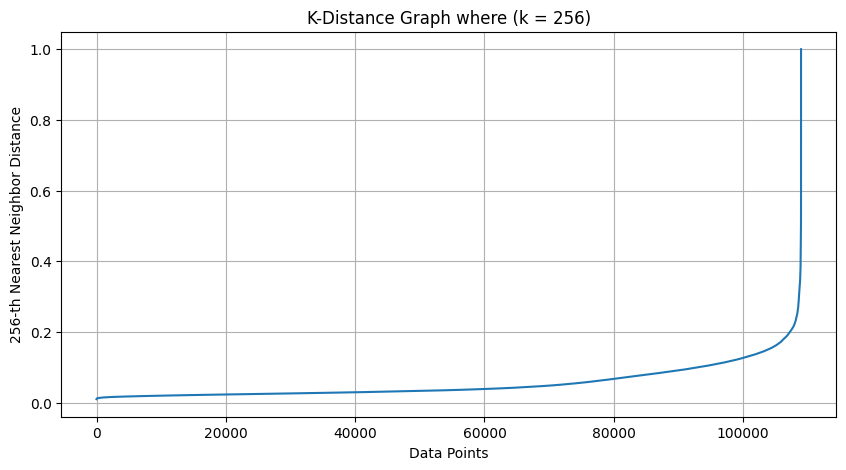

In [7]:
from sklearn.neighbors import NearestNeighbors

X = np.vstack(semantic_dataset['tokens'].apply(lambda tokens: document_vector(tokens, w2v_model)).to_numpy())

k = 256 # This is the same as min_samples for DBSCAN
neighbors = NearestNeighbors(n_neighbors=k, metric='cosine') # Using cosine because vectors are all roughly evenly scaled due to averaging. They may be really close together.
neighbors_fit = neighbors.fit(X)

distances, indices = neighbors_fit.kneighbors(X)
k_distances = distances[:, k - 1] # Get the k-th distance for each point.

k_distances = np.sort(k_distances)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(k_distances)
plt.title(f"K-Distance Graph where (k = {k})")
plt.xlabel("Data Points")
plt.ylabel(f"{k}-th Nearest Neighbor Distance")
plt.grid(True)
plt.show()

Based on this graph, it looks like a value of around 0.16 will work nicely for epsilon, as this the point where the graph turns sharply, indicating the maximum distance when core points are still in dense regions.

Now we can train DBSCAN with the obtained epsilon value.

__Be aware that DBSCAN takes a really long time and a lot of memory to train on this data with these hyperparameters.__

In [ ]:
from sklearn.cluster import DBSCAN

X = np.vstack(semantic_dataset['tokens'].apply(lambda tokens: document_vector(tokens, w2v_model)).to_numpy())

dbscan = DBSCAN(eps=0.16, min_samples=256, metric='cosine', n_jobs=-1, ) # Using cosine because vectors are all roughly evenly scaled due to averaging. They may be really close together.
output_labels = dbscan.fit_predict(X) # This uses a ridiculous amount of memory and takes a really long time. We couldn't afford to spend that long tweaking hyperparameters when it takes so long to train.

print("Finished running DBSCAN.")

n_clusters = len(set(output_labels)) - (1 if -1 in output_labels else 0)
n_noise = list(output_labels).count(-1)
n_percluster = [list(output_labels).count(c) for c in set(output_labels) if c != -1]

print(f"Estimated number of clusters: {n_clusters}")
print(f"Number of points for each cluster: {n_percluster}")
print(f"Estimated number of noise points: {n_noise}")

Finished running DBSCAN.
Estimated number of clusters: 2
Number of points for each cluster: [107749, 274]
Estimated number of noise points: 935


Create a 2D visualisation with UMAP

In [ ]:
import umap
X_embedded = umap.UMAP(n_neighbors=15, min_dist=0.1).fit_transform(X)

plt.figure(figsize=(10, 6))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=output_labels, s=10)
plt.title("DBSCAN Clusters Visualized with UMAP")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.colorbar(label='Cluster ID')
plt.show()

One big merged cluster. Epsilon is probably too high. Will turn down from 1.1 to 0.8 perhaps.